In [3]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from library import helpers, config

Study path is set to: /raven/ptmp/fklotzsche/Experiments/vMemEcc


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# %%
def get_epos(subID, epo_part, signaltype, condition, event_dict):
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + epo_part +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, epo_part, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)

def get_sensordata(subID, epo_part, signaltype, conditions, event_dict):
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   epo_part=epo_part,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n


def load_avgtfr(subID, condition, pwr_style='induced', 
                epo_part='fulllength', baseline=None, mode=None): 
    fpath = op.join(config.paths['05_tfrs'], pwr_style, 'tfr_lists', epo_part)
    fname = op.join(fpath, subID + '-collapsed-avgTFRs-tfr.h5')
    tfr_ = mne.time_frequency.read_tfrs(fname, condition=condition)
    if baseline is not None:
        tfr_.apply_baseline(baseline=baseline, mode=mode, verbose=False)
    return tfr_


def plot_tfr_side(ax, tfr, picks, cbar=True, tmin=None, tmax=None, 
                  vmin=None, vmax=None, title='', cmap='RdBu_r', mask=None):
        ha = tfr.copy().crop(tmin, tmax).plot(axes=ax, 
                                      show=False,
                                      baseline=(-1.1,-0.9),
                                      mode='mean', 
                                      colorbar=cbar,
                                      picks=picks, 
                                      combine='mean', 
                                      title=title, 
                                      #vmax=vmax, 
                                      #vmin=vmin, 
                                      cmap=cmap,
                                      mask=mask,
                                      verbose=False)
        ytick_range = ax.get_ylim()
        ytick_vals = np.arange(*np.round(ytick_range), 2)
        ax.yaxis.set_ticks(ytick_vals)
        ax.axvspan(0, 0.2, color='grey', alpha=0.3)
        ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
        ax.vlines((-0.8, 0, 0.2, 2.2), ymin=-1000, ymax=10000,
                   linestyles='dashed',
                   linewidth=0.5,
                   color='black')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.set_title('uV^2/Hz')
        return ha

def get_lateralized_power_difference(pwr_, picks_contra, picks_ipsi):
    if not len(picks_contra) == len(picks_ipsi):
        raise ValueError('Picks must be of same length.')
    pwr_diff = pwr_.copy().pick_channels(picks_contra, ordered=True)
    pwr_ordered_chans = pwr_.copy().reorder_channels(picks_contra + picks_ipsi)
    # keep flexible to use for data with 3 (AvgTFR) and 4 (EpoTFR) dimensions: 
    d_contra = pwr_ordered_chans._data[..., :len(picks_contra), :, :]
    d_ipsi = pwr_ordered_chans._data[..., len(picks_contra):, :, :]
    pwr_diff._data = d_contra - d_ipsi
    return pwr_diff


def run_cbp_test(data, p_initial = 0.05, p_thresh = 0.05, n_perm=10000):
    # number of permutations to run
    n_permutations = n_perm
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    adjacency = None
    tail = 0.  # for two sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=True, tail=tail,
        step_down_p=0.05, adjacency=adjacency,
        n_permutations=n_permutations, seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)


def plot_cbp_result(ax, T_obs, clusters, cluster_p_values, p_thresh, 
                        cbp_times=None, times_full=None):
    if cbp_times is None:
        if times_full is None: 
            times_full = range(len(T_obs))
        cbp_times = times_full
    if times_full is None: 
        times_full = cbp_times
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(cbp_times[c[0]], cbp_times[c[- 1]],
                            color='r', alpha=0.3)
    hf = ax.plot(cbp_times, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
            ylim=y_max, xlim=times_full[np.array([0,-1])])
    #fig.tight_layout(pad=0.5)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([-0.8, 0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    #ax.set_aspect(0.33)
    ax.set_title('')
    #ax.set_aspect('auto', adjustable='datalim')
    #ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def plot_main_eff(cond, cond_dict, data, ax, n_boot=1000):
    sns.lineplot(x='time', y='pwr', hue=cond, data=data, n_boot=n_boot, 
                 palette=[config.colors[l] for l in cond_dict[cond]], ax=ax,
                 linewidth=0.5, legend=False)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
    ax.set_ylabel('V$^2$')
    ax.set_xlabel('Time (s)')
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
    ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
            linestyles='dashed',
            linewidth=0.5,
            color='black')
    ax.hlines(0, xmin=-1.1, xmax=2.3,
              linewidth=0.5,
              color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



def get_tfr(epos, picks='all', average=True, freqs=None):
    if freqs is None:
        freqs = np.concatenate([np.arange(6, 26, 1)])  # , np.arange(16,30,2)])
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power = mne.time_frequency.tfr_morlet(epos, picks=picks, freqs=freqs,
                                          n_cycles=n_cycles, use_fft=True,
                                          return_itc=False, average=average,
                                          decim=1, n_jobs=-2,
                                          verbose=False)
    return power


def get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13),
                               t_start=None, t_stop=None, pwr_style='induced',
                               epo_part='fulllength', 
                               picks=config.chans_CDA_all):
    fpath = op.join(config.paths['03_preproc-pooled'], epo_part, 'collapsed')
    epos_ = helpers.load_data(f'{subID}-{epo_part}-collapsed',
                              fpath, '-epo',
                              verbose=False)
    
    # Shift time, so that 0 == Stimulus Onset:
    epos_ = epos_.shift_time(-config.times_dict['cue_dur'])
    
    if pwr_style == 'induced':
        epos_ = epos_.subtract_evoked()

    event_dict = helpers.get_event_dict(epos_.event_id)

    sub_dfs = list()

    for load in ['LoadLow', 'LoadHigh']:
        for ecc in ['EccS', 'EccM', 'EccL']:
            epos_cond = epos_[event_dict[load]][event_dict[ecc]]
            # Get TFRs and calc lat power:
            tfrs_cond = get_tfr(epos_cond,
                                   picks=picks, 
                                   average=False, 
                                   freqs=freqs_to_avg)
            tfrs_cond.apply_baseline(baseline=(-(config.times_dict['cue_dur']+0.3), 
                                               -(config.times_dict['cue_dur']+0.1)), 
                                     mode='mean',
                                     verbose=False)
            tfr_lat = get_lateralized_power_difference(tfrs_cond, 
                                                       config.chans_CDA_dict['Contra'], 
                                                       config.chans_CDA_dict['Ipsi'])
            # Crop to cluster times: 
            tfr_lat.crop(t_start, t_stop)
            tfr_lat_df = tfr_lat.to_data_frame()
            tfr_lat_df = tfr_lat_df.loc[:, ['epoch'] + tfr_lat.ch_names]
            tfr_lat_df = tfr_lat_df.groupby('epoch').agg('mean').reset_index()
            tfr_lat_df['mean_pwr_diff'] = tfr_lat_df.loc[:, tfr_lat.ch_names].mean(axis=1)
            tfr_lat_df['c_StimN'] = load
            tfr_lat_df['c_Ecc'] = ecc
            tfr_lat_df['trial_num'] = tfr_lat_df.epoch + 1 # correcting for 0 indexing in python
            tfr_lat_df = tfr_lat_df.drop('epoch', axis=1)
            
            # store in list
            sub_dfs.append(tfr_lat_df)

    sub_df = pd.concat(sub_dfs, axis=0)
    sub_df['subID'] = subID
    return(sub_df)


def get_condition_pwrdiff_df(factor, cond_dict,
                             sub_list_str,
                             pwr_style="induced",
                             epo_part="fulllength",
                             roi_contra=config.chans_CDA_dict['Contra'],
                             roi_ipsi=config.chans_CDA_dict['Ipsi'],
                             avg_chans=True):
    df_list = list()
    df_load_long = pd.DataFrame()
    
    for cond in cond_dict[factor]:
        tfr_list = [load_avgtfr(subID, cond, pwr_style, epo_part, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') for subID in sub_list_str]
        times = tfr_list[0].times

        diffs_ = [get_lateralized_power_difference(tfr, 
                                                   roi_contra, 
                                                   roi_ipsi) for 
                tfr in tfr_list]

        frqs_idx = [(8 <= diffs_[0].freqs) & (diffs_[0].freqs <= 13)]
        chans = diffs_[0].ch_names
        diffs_mean = [d.data[:, frqs_idx[0], :].mean(axis=1) for d in diffs_]
        diffs_mean_dfs = [pd.DataFrame(np.array(df).swapaxes(1,0), columns=chans) for df in diffs_mean]
        df_res = pd.DataFrame()
        for df, subID in zip(diffs_mean_dfs, sub_list_str):
            df['time'] = times
            df[factor] = cond
            df['subID'] = subID
            df_out = df.melt(id_vars=['time', factor, 'subID'], var_name='ch_name', value_name='pwr')
            if avg_chans:
                df_out = df_out.groupby(['time', factor, 'subID']).mean()
            df_res = pd.concat([df_res, df_out.reset_index()])
        df_load_long = pd.concat([df_load_long, df_res])
    
    df_load_long = df_load_long.reset_index(drop=True)


    return(df_load_long)

In [6]:
## Setup

plt.rcParams['font.size'] = 7
plt.rcParams["legend.fontsize"] = 7
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Loading the TFRs from disc

Running the next two cells will take quite long. Then you have the TFRs in memory and can fairly quickly work with them. 


In [7]:
#%%
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

part_epo = 'fulllength'
pwr_style = 'induced'  # 'evoked' # 
cond_dict = {'Load': ['LoadLow', 'LoadHigh'], 
             'Ecc': ['EccS', 'EccM', 'EccL']}


In [8]:
# Load the grand average:

fpath = op.join(config.paths['05_tfrs'], pwr_style, 'tfr_lists', part_epo)
fname = op.join(fpath, 'grandavg-allconds-tfr.h5')

grand_avgtfr_all = mne.time_frequency.read_tfrs(op.join(fpath, fname))[0]
# If this fails bc you do not have the file yet, you have to run the cell that loads the `tfr_list` first 
# (see below)


#%% Set up params:
times = grand_avgtfr_all.times
freqs = grand_avgtfr_all.freqs
ch_names = grand_avgtfr_all.ch_names

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/grandavg-allconds-tfr.h5 ...


First, we plot the TFR per "hemisphere" (i.e., the ROI on the contralateral and the ipsilateral side);

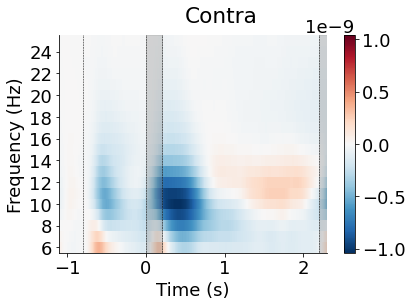

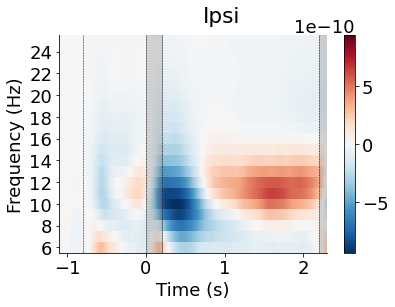

In [9]:
# Plot TF diag per hemisphere across all conditions:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams['font.size'] = 18
for side in ['Contra', 'Ipsi']:
    fig, ax = plt.subplots(1, figsize=(6,4))
    tf_contra = plot_tfr_side(ax, grand_avgtfr_all, picks=config.chans_CDA_dict[side], 
                tmin=-1.1, tmax=2.3, title=side, cbar=True, 
                vmin=-6e-10, vmax=6e-10)

    # Save it: 
    fpath = op.join(config.paths["plots"], 'TFR', part_epo)
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, f'grandavgTFR_{side}.svg')
    fig.savefig(fname, bbox_inches="tight")

Next step: we calculate the lateralized TFR (i.e., the difference between the two hemispheres):

In [10]:
#%% Calculate the difference between the hemispheres:
diff_avgtfr_all = get_lateralized_power_difference(grand_avgtfr_all, 
                                                 config.chans_CDA_dict['Contra'], 
                                                 config.chans_CDA_dict['Ipsi'])

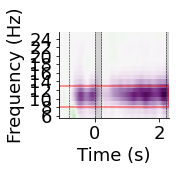

In [11]:
cm = 1/2.54
fig, ax = plt.subplots(1, figsize=(5*cm,4*cm))
tf_contra = plot_tfr_side(ax, diff_avgtfr_all, picks='all', 
            tmin=-1.1, tmax=2.3,
            title='',  # 'Contra - Ipsi',
            cbar=False,  # True, 
            vmin=-4e-10, vmax=4e-10, cmap='PRGn')

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference.pdf')
fig.savefig(fname, bbox_inches="tight")

# Create version with red box around classical alpha range (8-12Hz):
rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=1.6, edgecolor='r', facecolor='none', alpha=0.5)
ax.add_patch(rect)
# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference_classAlpha.pdf')
fig.savefig(fname, bbox_inches="tight")

We run a CBP test to produce a masked (thresholded) version of this plot, showing only the significant clusters (p <.05):

In [12]:
#%% get list with avg TFRs for all trials and conditions: 
# 
# !!! THIS BLOCK TAKES AGES
# !!! ONLY RUN IF YOU WANT TO DO THE CBP, SINGLE SUBJECT STUFF, OR YOU DO NOT HAVE THE GRAND AVF FILE YET.

# SET THIS TO TRUE IF YOU WANT TO POTENTAILLY OVERWRITE THE OLD FILE:
overwrite_grandavg_file =False


tfr_list = [load_avgtfr(subID, 'all', pwr_style, part_epo, 
                        baseline=(-(config.times_dict['cue_dur']+0.3), 
                                  -(config.times_dict['cue_dur']+0.1)), 
                        mode='mean') 
            for subID in sub_list_str]

# Calculate the grand average:
grand_avgtfr_all = mne.grand_average(tfr_list)

fpath = op.join(config.paths['05_tfrs'], pwr_style, 'tfr_lists', part_epo)
fname = op.join(fpath, 'grandavg-allconds-tfr.h5')

if overwrite_grandavg_file:
    grand_avgtfr_all.save(op.join(fpath, fname))
del(fpath, fname)

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/in

In [13]:
#%% Get the difference per subject: 

diffs_avgtfr_all = [get_lateralized_power_difference(tfr, 
                                                   config.chans_CDA_dict['Contra'], 
                                                   config.chans_CDA_dict['Ipsi']) for 
                    tfr in tfr_list]

cropped_data = np.array([d.copy().crop(-1.1, 2.3).data.mean(axis=0) for d in diffs_avgtfr_all])
adjacency = mne.stats.combine_adjacency(*cropped_data.shape[-2:])
threshold = None  # let MNE calc threshold
n_permutations = 10000  
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(cropped_data, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True,
                                   n_jobs=-2)

T_obs_mask = np.full(T_obs.shape, False)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_mask[c] = True

Using a threshold of 2.085963
stat_fun(H1): min=-4.681591 max=3.339622
Running initial clustering
Found 13 clusters
Permuting 9999 times...


/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


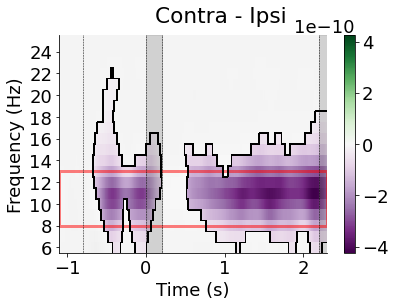

In [14]:
fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_avgtfr_all, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=True, 
            vmin=-4e-10, vmax=4e-10, cmap='PRGn', mask=T_obs_mask)

# Add red box around classical alpha range (8-12Hz):
rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
ax.add_patch(rect)
# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference_classAlpha_masked.svg')
fig.savefig(fname, bbox_inches="tight")

We produce one of these plots per participant to check for consistency:

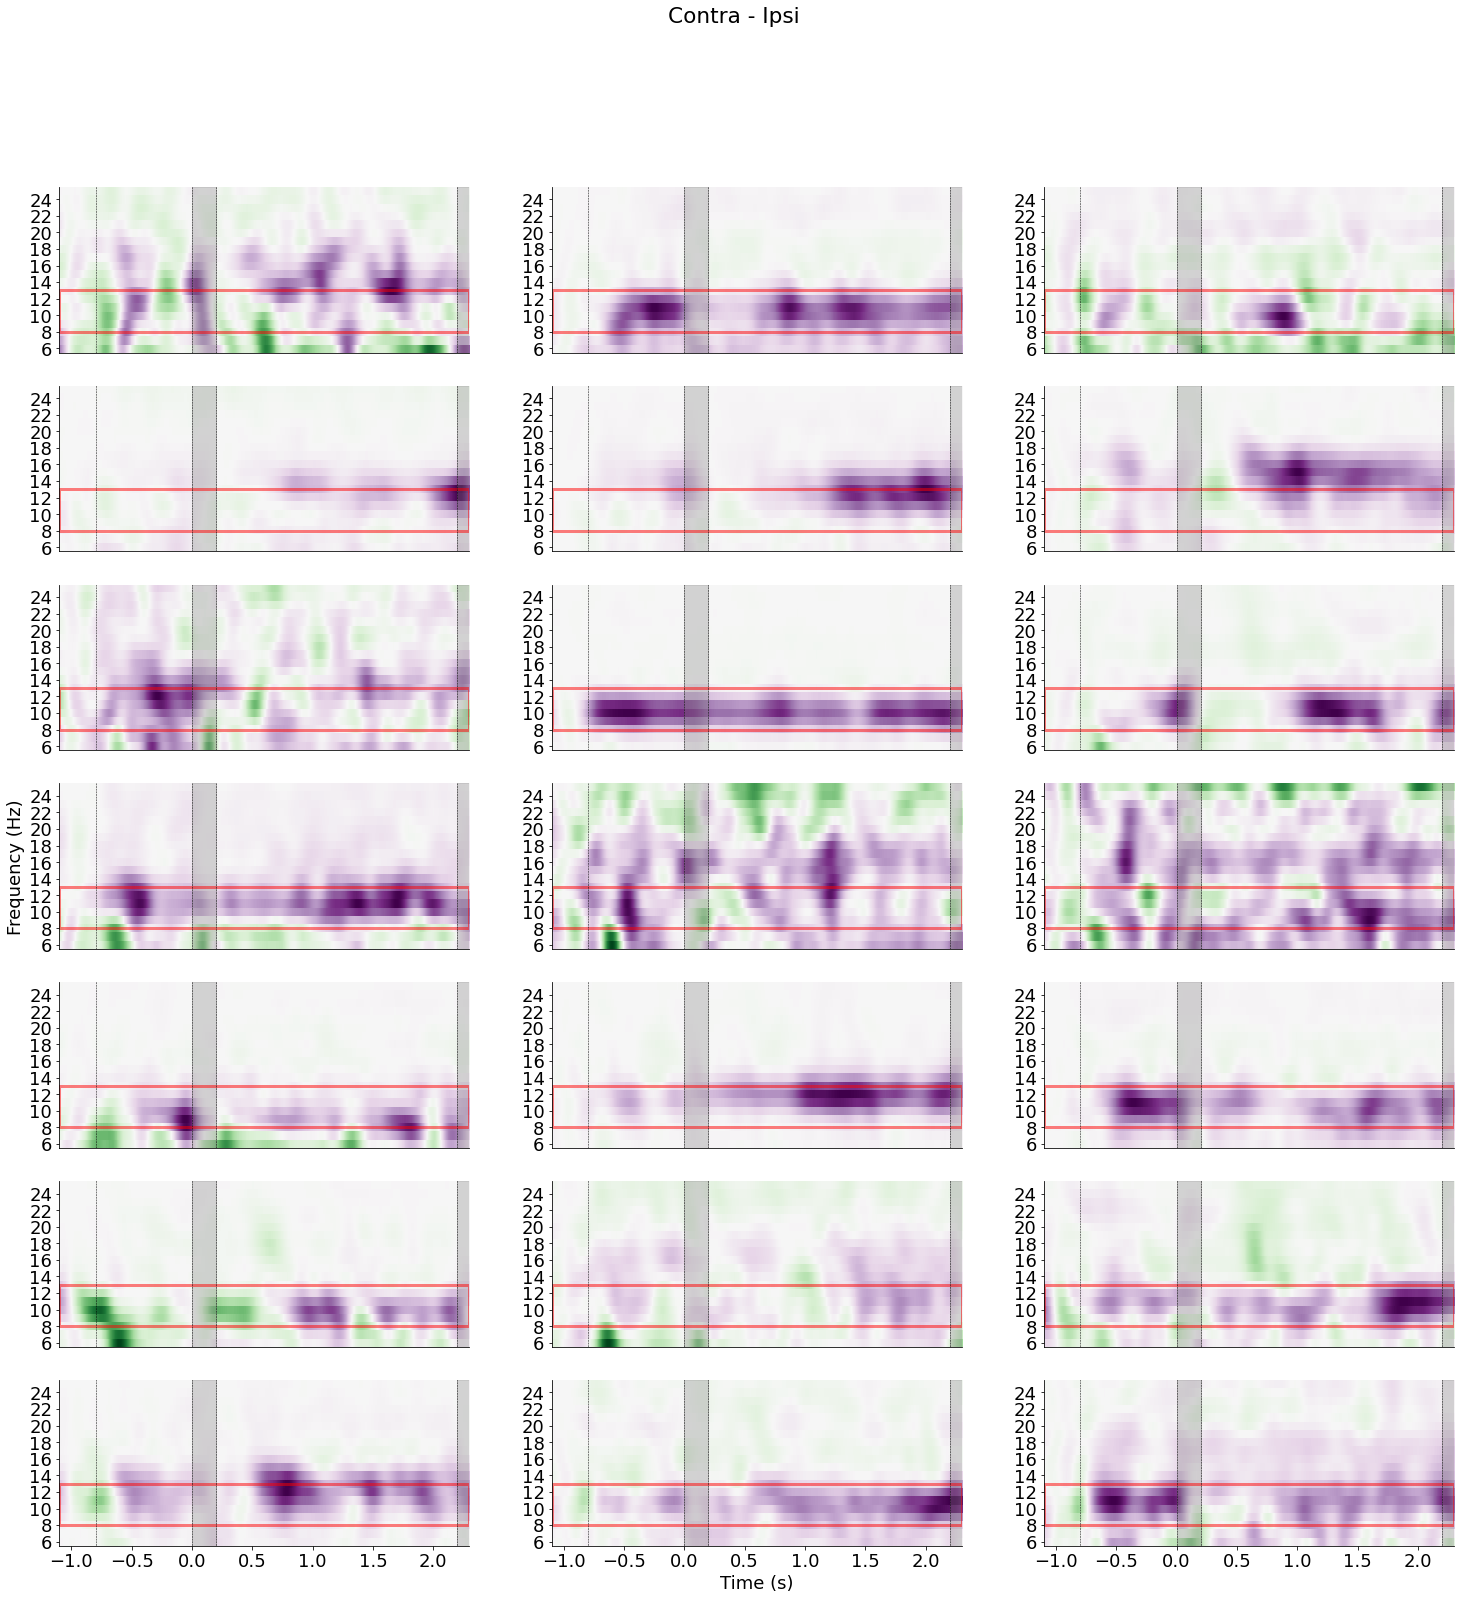

In [15]:



##############################################################################################
#%% Make single subject plots:
fig, ax = plt.subplots(7,3, figsize=(25,25))
for tfr_, ax_ in zip(diffs_avgtfr_all, ax.reshape(-1)):
    plot_tfr_side(ax_, tfr_, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=False, 
            cmap='PRGn')
    rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
    ax_.add_patch(rect)
    ax_.xaxis.label.set_visible(False)
    ax_.yaxis.label.set_visible(False)
for ax_ in ax[:-1].reshape(-1):
    ax_.xaxis.set_visible(False)
ax[3,0].yaxis.label.set_visible(True)
ax[6,1].xaxis.label.set_visible(True)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'singlesubs_avgTFR_Difference.png')
fig.savefig(fname, bbox_inches="tight")

Now we plot the difference (in lateralized power) between the two memory load conditions (high  vs low load). According to Sauseng et al. (2009) we should see stronger (more negative) alpha lateralization for the higher memory load:

In [16]:
#%% get dict with avg TFRs per load and eccentricity condition: !!! THIS BLOCK TAKES EVEN LONGER
all_conds = [c for fac in cond_dict for c in cond_dict[fac]]
tfr_by_cond = {cond: [load_avgtfr(subID, cond, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                                -(config.times_dict['cue_dur']+0.1)),
                    mode='mean') 
                    for subID in sub_list_str]
               for cond in all_conds}

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/in

Identifying common channels ...
Identifying common channels ...


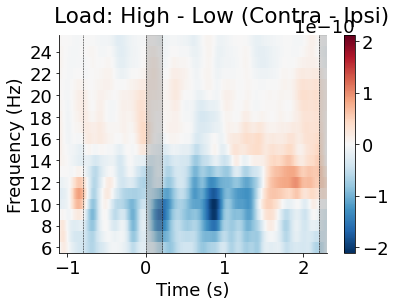

In [17]:
# Calc overall difference between high and low load:
load = 'LoadLow'
side = 'Ipsi'
ga = defaultdict(mne.EvokedArray)
for load in ['LoadHigh', 'LoadLow']:
    tmp = tfr_by_cond[load]
    ga[load] = mne.grand_average(tmp)

diff_ga_data = ga['LoadHigh'].data - ga['LoadLow'].data

info = ga['LoadHigh'].info
diff_ga = mne.time_frequency.AverageTFR(info, diff_ga_data, times, freqs, nave=21)

diff_diff = get_lateralized_power_difference(diff_ga, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi'])

fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_diff, picks=config.chans_CDA_dict['Contra'], 
            tmin=-1.1, tmax=2.3, title="Load: High - Low (Contra - Ipsi)", cbar=True, 
            vmin=-6e-10, vmax=6e-10)

We run a quick CBP test to check if anything in this plot is significant:

In [18]:
tt = dict()
for load in ['LoadHigh', 'LoadLow']:
    tmp = tfr_by_cond[load]
    tt[load] = [get_lateralized_power_difference(t, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi']) for t in tmp]
ddd = np.array([(h.data - l.data).mean(0) for h,l in zip(tt['LoadHigh'], tt['LoadLow'])])
adjacency = mne.stats.combine_adjacency(*ddd.shape[-2:])
threshold = None  # let MNE calc threshold
n_permutations = 10000  
p_thresh = 0.05
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(ddd, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True,
                                   n_jobs=-2)
print(f"Test found {np.sum(cluster_p_values < p_thresh)} significant clusters (p<.05).")

Using a threshold of 2.085963
stat_fun(H1): min=-3.960081 max=2.930283
Running initial clustering
Found 19 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Test found 0 significant clusters (p<.05).


This does not seem to be the case. Maybe if we average all alpha frequencies?

Now we extract the mean power in the alpha range (8-13Hz) over time and plot it:

stat_fun(H1): min=-4.099005 max=0.289610
Running initial clustering
Found 2 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.


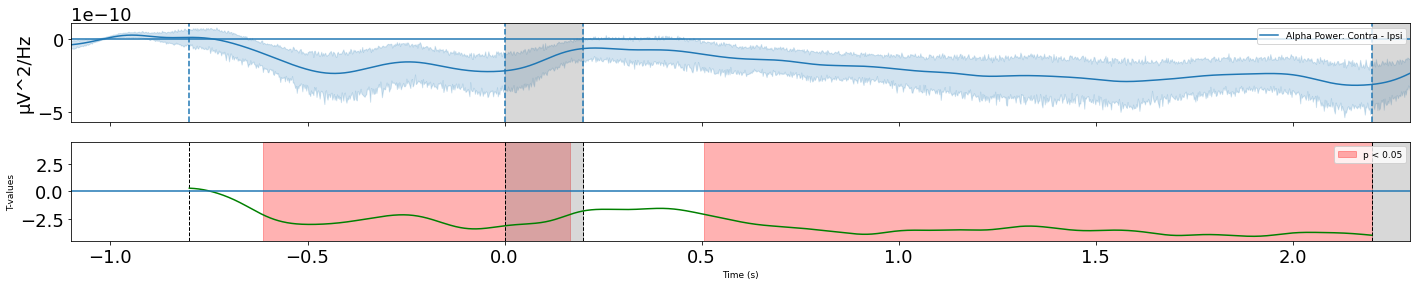

In [19]:
#%% Extract standard alpha (8-13Hz):
frqs_idx = [(8 <= diffs_avgtfr_all[0].freqs) & (diffs_avgtfr_all[0].freqs <= 13)]
diffs_stdalpha_mean = [d.data[:, frqs_idx[0], :].mean(axis=(0,1)) for d in diffs_avgtfr_all]

##############################################################################################
# plot it in 2D: 
plt_df = pd.DataFrame(np.array(diffs_stdalpha_mean).swapaxes(1,0), 
                      columns=sub_list_str)
plt_df['time'] = times
plt_df_long = plt_df.melt(id_vars='time', var_name='subID', value_name='pwr')
plt_df_long['hue'] = 'Alpha Power: Contra - Ipsi'

fig, axes = plt.subplots(2, figsize=(24,4), sharex=True)
ax = axes[0]
sns.lineplot(x='time', y='pwr', hue='hue', data=plt_df_long, n_boot=100, ax=ax)
ytick_range = ax.get_ylim()
ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
ax.set_ylabel('µV^2/Hz')
#ax.set_xlabel('Time (s)')
#ytick_vals = np.arange(*np.round(ytick_range), 2)
#ax.yaxis.set_ticks(ytick_vals)
ax.axvspan(0, 0.2, color='grey', alpha=0.3)
ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
          linestyles='dashed')
ax.hlines(0, xmin=-1.1, xmax=2.3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1, prop={'size': 9})
ax.xaxis.label.set_visible(False)

#%% run CBP test on classical alpha data (sub x times):
# crop to time of interest: 
mask_time = [(times >= -0.8) & (times <= 2.2)]
data = np.array(diffs_stdalpha_mean)[:, mask_time[0]]

threshold = None  # let MNE calc threshold
n_permutations = 10000  
p_thresh = 0.05

T_obs, clusters, c_pvals = run_cbp_test(data, 
                                        p_initial=0.05,
                                        p_thresh=p_thresh,
                                        n_perm=10000)


##############################################################################################
# add it to figure:
ax = axes[1]
plot_cbp_result(ax, T_obs, clusters, c_pvals, 0.05, 
                         cbp_times=times[mask_time[0]], 
                         times_full=np.arange(-1.1, 2.3, 0.002))

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'classAlpha_Difference.png')
fig.savefig(fname, bbox_inches="tight")

In [20]:
# # Extract the values:
cbp_times = times[mask_time[0]]
sign_cluster_times = {}
# retention interval: 2nd cluster
cluster_times = cbp_times[clusters[1][0]]
sign_cluster_times['retention'] = cluster_times
# cue interval: 1st cluster
cluster_times = cbp_times[clusters[0][0]]
sign_cluster_times['cue'] = cluster_times

helpers.extract_var("latalpha_cbp_2ndlvl_pval", p_thresh, is_pval=True)

helpers.extract_var("tfr_alphalat_retention_sign_cluster_t_start", sign_cluster_times['retention'][0] * 1000, 
                    exp_format=".3f")
helpers.extract_var("tfr_alphalat_retention_sign_cluster_t_end", sign_cluster_times['retention'][-1] * 1000, 
                    exp_format=".3f")
helpers.extract_var("tfr_alphalat_cue_sign_cluster_t_start", sign_cluster_times['cue'][0] * 1000, 
                    exp_format=".3f")
helpers.extract_var("tfr_alphalat_cue_sign_cluster_t_end", sign_cluster_times['cue'][-1] * 1000, 
                    exp_format=".3f")

We write out CSV files with the mean lateralized alpha power per trial so we can read it into R and run our stats there:

In [21]:
#%% Export single trial data about lateral. difference in alpha power 
# for the CDA ROI during the sign cluster:

# For the retention intervall, we look at the 2nd cluster.
cluster_dict = {'name': 'retention', 
                't_start': times[mask_time[0]][clusters[1]][0], 
                't_stop': times[mask_time[0]][clusters[1]][-1]}

mean_pwrdiff_list = list()
for sub in sub_list:
    subID = 'VME_S%02d' % sub
    mean_pwrdiff_df = get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13), 
                                                 t_start= cluster_dict['t_start'], 
                                                 t_stop= cluster_dict['t_stop'])
    # Write subject data to disk:
    fpath = op.join(config.paths["05_tfrs-summaries"], pwr_style, cluster_dict['name'])
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, f'{subID}-mean_pwrdiff_{cluster_dict["name"]}.csv')
    mean_pwrdiff_df.to_csv(fname, index=False, float_format="%.25f")
    mean_pwrdiff_list.append(mean_pwrdiff_df)

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG, LO2, LO1, IO2, VEOG, ECG, IO1
[done]
Subtracting Evoked from Epochs
   

In [22]:
mean_pwrdiff_all_df = pd.concat(mean_pwrdiff_list)
# Write subject data to disk:
fpath = op.join(config.paths["05_tfrs-summaries"], pwr_style, cluster_dict['name'], 
                'global_summary')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'allsubjects-mean_pwrdiff_{cluster_dict["name"]}.csv')
mean_pwrdiff_all_df.to_csv(fname, index=False, float_format="%.25f")

For each of the main factors, we load the lateralized alpha data into a dataframe. This allows easier plotting. 
!!! This cell runs for pretty long. Afterwards you have the DFs in memory and can efficiently use them.

In [23]:
epo_part = "fulllength"
pwr_style = "induced"


In [24]:
fpath = op.join(config.paths['05_tfrs'], pwr_style, 'tfr_lists', part_epo)
fname_load = 'df_load_long-tfr.csv'
fname_ecc = 'df_ecc_long-tfr.csv'

load_dfs_from_disk = True

if (load_dfs_from_disk):
    load_df_long = pd.read_csv(op.join(fpath, fname_load))
    ecc_df_long = pd.read_csv(op.join(fpath, fname_ecc))

else:
    load_df_long = get_condition_pwrdiff_df('Load', cond_dict, sub_list_str, pwr_style=pwr_style, epo_part=epo_part, avg_chans=True)
    ecc_df_long = get_condition_pwrdiff_df('Ecc', cond_dict, sub_list_str, pwr_style=pwr_style, epo_part=epo_part, avg_chans=True)
    load_df_long.to_csv(op.join(fpath, fname_load), index=False)
    ecc_df_long.to_csv(op.join(fpath, fname_ecc), index=False)
del(fpath, fname)

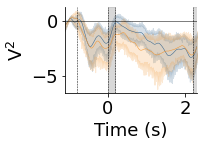

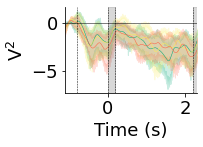

In [25]:
import matplotlib

# just for plotting to get rid of the annoying scientific notation on the axis
load_df_long['pwr'] *= 1e10
ecc_df_long['pwr'] *= 1e10

#Plot main effect Load:
fig, ax = plt.subplots(1, figsize=(6*cm,4*cm))
plot_main_eff('Load', cond_dict, load_df_long, ax, n_boot=100) # <--- increase "n_boot" for better CIs (takes longer to run)
# # Fake legend:
# custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['LoadLow'], lw=2),
#                 matplotlib.lines.Line2D([0], [0], color=config.colors['LoadHigh'], lw=2)]
# ax.legend(handles=custom_lines, title='Size Memory Array', labels=['2', '4'], loc=1, prop={'size': 9}, ncol=2)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_load.pdf')
fig.savefig(fname, bbox_inches="tight")

# Plot main effect Ecc:
fig, ax = plt.subplots(1, figsize=(6*cm,4*cm))
plot_main_eff('Ecc', cond_dict, ecc_df_long, ax, n_boot=100)
## Fake legend:
# custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['EccS'], lw=2),
#                 matplotlib.lines.Line2D([0], [0], color=config.colors['EccM'], lw=2),
#                 matplotlib.lines.Line2D([0], [0], color=config.colors['EccL'], lw=2)]
# ax.legend(handles=custom_lines, title='Eccentricity', labels=['4°', '9°', '14°'], 
#           loc=1, prop={'size': 9}, ncol=3)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_ecc.pdf')
fig.savefig(fname, bbox_inches="tight")

# Supplementary Analyses

## 1. rmANOVA on time x frequencies – do we find a sign. effect of MemLoad or Ecc? 
We run a repeated measures ANOVA on the power values (averaged within the bilateral ROIs).
Mostly building on code from [this MNE tutorial](https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py).

In [26]:
#%% run rep-meas ANOVA on power: 

# building on code from: 
# https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py


#%%
df_list = list()
for load in cond_dict['Load']:
    for ecc in cond_dict['Ecc']:
        tfr_list = [load_avgtfr(subID, load+ecc, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='percent') for subID in sub_list_str]


        diffs_ = [get_lateralized_power_difference(tfr, 
                                                config.chans_CDA_dict['Contra'], 
                                                config.chans_CDA_dict['Ipsi']) for 
                tfr in tfr_list]
        for d in diffs_:
            dat_ = d.crop(0.2, 2.2)
            df_list.append(dat_.data.mean(axis=0))
    times = dat_.times
    freqs = dat_.freqs
#%%

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/in

In [27]:
# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = 'A*B'
n_levels = np.multiply(*factor_levels)
n_freqs = df_list[0].shape[-2]
n_times = df_list[0].shape[-1]
n_subs = int(len(df_list) / n_levels)

# Shape data matrix: subjects x effects x n_freqs*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_freqs*n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)
effect_labels = ['Load', 'Ecc', 'Load x Ecc']

/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/stats/parametric.py:399: RuntimeWarning: invalid value encountered in long_scalars
  mse = (np.sum(np.sum(y * y, axis=2), axis=1) - ss) / (df2 / df1)


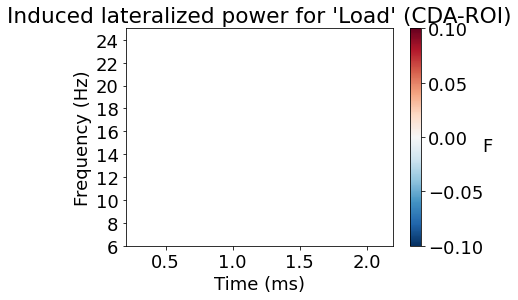

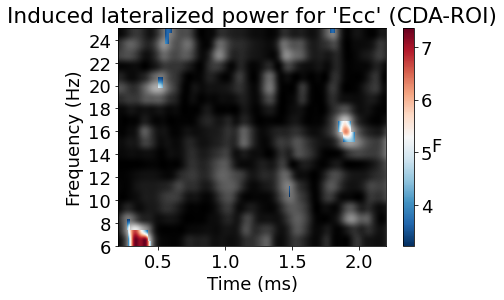

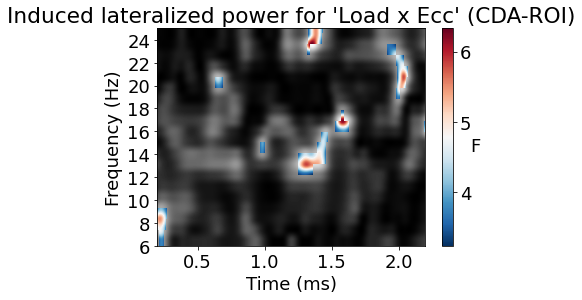

In [28]:
# Plot result:
for effect, sig, effect_label in zip(fvals, pvals, effect_labels):
    f = plt.figure()
    # show naive F-values in gray
    plt.imshow(effect.reshape(n_freqs, n_times), cmap=plt.cm.gray, extent=[times[0],
               times[-1], freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
    # create mask for significant Time-frequency locations
    effect[sig >= 0.05] = np.nan
    plt.imshow(effect.reshape(n_freqs, n_times), cmap='RdBu_r', extent=[times[0],
               times[-1], freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
    cb = plt.colorbar()
    cb.set_label(label='F', rotation=0)
    ytick_range = f.axes[0].get_ylim()
    ytick_vals = np.arange(*np.round(ytick_range), 2)
    f.axes[0].yaxis.set_ticks(ytick_vals)
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(r"Induced lateralized power for '%s' (%s)" % (effect_label, 'CDA-ROI'))
    plt.show()

stat_fun(H1): min=0.000000 max=23.240352
Running initial clustering
Found 28 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


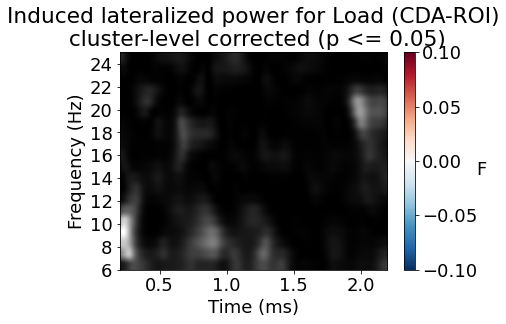

In [29]:
# Use CBP test to correct for multiple-comparisons correction:

# We need to do this separately for each effect:
effects='A'

effects_dict = {'A': 'Load',
                'B': 'Eccentricity',
                'A:B': 'Load x Eccentricity'}

def stat_fun(*args):
    return f_mway_rm(np.reshape(args, (len(sub_list), n_levels, n_freqs, len(times))), 
                     factor_levels=factor_levels,
                     effects=effects, return_pvals=False)[0]


# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = 0.05  # set threshold rather high to save some time
f_thresh = f_threshold_mway_rm(len(sub_list), factor_levels, effects,
                               pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 1000  # Save some time (the test won't be too sensitive ...)
T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
    subtfr_mway_data, stat_fun=stat_fun, threshold=f_thresh, tail=tail, n_jobs=-2,
    n_permutations=n_permutations, buffer_size=None, out_type='mask')

# Plot it:
T_obs_plot = np.ones_like(T_obs) *np.nan
for c, p in zip(clusters, cluster_p_values):
    if p < .05: 
        T_obs_plot[c] = T_obs[c]

f = plt.figure()
for f_image, cmap in zip([T_obs, T_obs_plot], [plt.cm.gray, 'RdBu_r']):
    plt.imshow(f_image.reshape(n_freqs, n_times), cmap=cmap, extent=[times[0], times[-1],
               freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
cb = plt.colorbar()
cb.set_label(label='F', rotation=0)
ytick_range = f.axes[0].get_ylim()
ytick_vals = np.arange(*np.round(ytick_range), 2)
f.axes[0].yaxis.set_ticks(ytick_vals)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f"Induced lateralized power for {effects_dict[effects]} (%s)\n"
          " cluster-level corrected (p <= 0.05)" % 'CDA-ROI')

plt.show()

Summary: after correction for MCs, no effect is significant. 

## 2. Is our ROI representative – and evenly so across the eccentricities?

In [30]:

# make same plots as for CDA suppl. analyses

def plot_mean_latalpha_roi(mean_cda, ch_names_lat, ax, pal=None):
    sorted_w_idx = sorted([(v,i) for i,v in enumerate(mean_cda.mean(axis=0))])
    idx_sorted = [i[1] for i in sorted_w_idx]

    idx_roi = [ch_names_lat.index(c) for c in config.chans_CDA_dict['Left']]

    cda_df = pd.DataFrame()

    cda_roi = np.mean(mean_cda[:,idx_roi], axis=-1)
    cda_df['our ROI'] = cda_roi
    cda_df['   '] = [-999] * len(mean_cda)

    our_roi_str = ['PO3/4', 'PO7/8', 'O1/2', 'P3/4', 'P5/6']

    n_rois = 20
    for i in range(n_rois):
        idx_sel = idx_sorted[:i+1]
        # cda_sel = np.mean(mean_cda[:,idx_sel], axis=-1)  # <-- plot mean for cumulative ROI
        cda_sel = mean_cda[:,idx_sel[-1]]  # <-- plot channels separately
        name =   ch_names_lat[idx_sorted[i] ] + '/' + str(int(ch_names_lat[idx_sorted[i] ][-1])+1)#  (i>0)*'+ ' + 
        if name in our_roi_str:
            name += '*'
        cda_df[name] = cda_sel

    if pal is None:
        cols = list(sns.color_palette('viridis_r', n_rois+1))
        cols.insert(0, 'turquoise')  # cols[4])
        pal ={n:c for n,c in zip(cda_df.columns, cols)}
    else:
        pal_c = pal.copy()
        for cn in cda_df:
            comps = [p for p in pal_c if ((cn in p) or (p in cn))]
            if any(comps):
                pal[cn] = pal[comps[0]]
            else:
                pal[cn] = 'grey'

    # cda_df.boxplot(vert=False)
    val_name = 'mean lat. alpha power [95%CI] (V^2)'
    ll = cda_df.melt(var_name='ROI', value_name=val_name)
    xx = list(range(10)) + [13]
    sns.pointplot(data=ll, x='ROI',
                    y=val_name, palette=pal,
                    ci=95,  # errorbar='sd',
                    #xlim=(-0.6,0.2),
                    dodge=3.0,
                    ax=ax)
    xticks = ax.get_xticks()
    xlabs = ax.get_xticklabels()
    ax.axhline(np.mean(cda_roi), color=pal['our ROI'], linestyle=':')
    ax.set_xticks(ticks=xticks, labels=xlabs, rotation=65, ha='center')
    ax.set_ylim(-0.5e-9, 0.1e-9)

    return pal

In [31]:
# get pwr diff data (alpha) for all channels and time points
region_dict = mne.channels.make_1020_channel_selections(grand_avgtfr_all.info)

diffs = get_condition_pwrdiff_df('Ecc', cond_dict, sub_list_str, 
                                roi_contra=[ch_names[i] for i in region_dict['Left']],
                                roi_ipsi=[ch_names[i] for i in region_dict['Right']],
                                avg_chans=False)
                                


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/in

In [121]:
# crop to sign cluster & average per channel

diffs_cluster = diffs[(diffs['time'] >= cluster_dict['t_start']) & 
                      (diffs['time'] <= cluster_dict['t_stop'])]


In [123]:
mean_diffs = dict()
mean_latalpha = dict()
mean_diffs['all'] = diffs_cluster.groupby(['subID', 'ch_name'])['pwr'].mean().reset_index()
mean_latalpha['all'] = mean_diffs['all'].pivot(index='subID', columns='ch_name', values='pwr')

conds_ecc = ['EccS', 'EccM', 'EccL']
for cond in conds_ecc:
    mean_diffs[cond] = diffs_cluster[diffs_cluster['Ecc']==cond].groupby(['subID', 'ch_name'])['pwr'].mean().reset_index()
    mean_latalpha[cond] = mean_diffs[cond].pivot(index='subID', columns='ch_name', values='pwr')
ch_names_df = list(mean_latalpha['all'].columns)

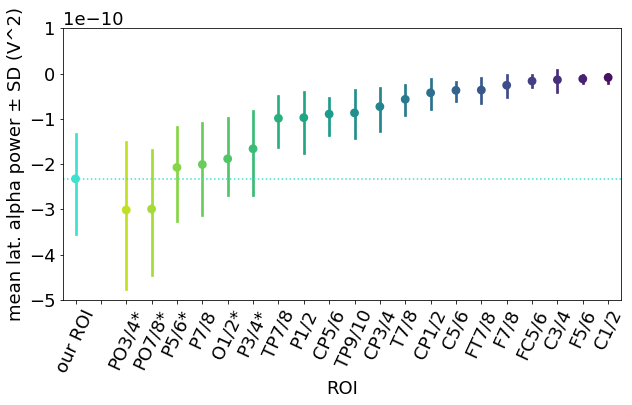

In [124]:
fig1, ax1 = plt.subplots(1,1, figsize=(10, 5))
pal = plot_mean_latalpha_roi(np.array(mean_latalpha['all']), ch_names_df, ax=ax1)

/tmp/ipykernel_32854/3139642709.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


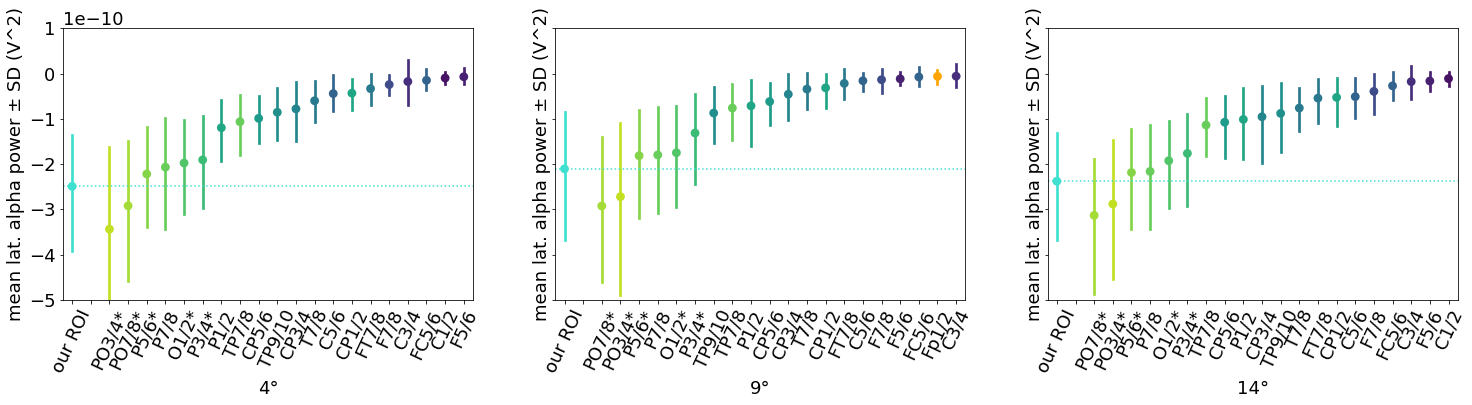

In [125]:

## per Ecc

fig2, axes = plt.subplots(1,3, sharey=True, figsize=(25,5))


for cond, ax in zip(conds_ecc, axes):
    plot_mean_latalpha_roi(mean_cda=np.array(mean_latalpha[cond]), ch_names_lat=ch_names_df, ax=ax, pal=pal) 
    ax.set_xlabel(config.labels[cond])
fig.tight_layout()

## 3. rmANOVA on time x channels (for avarage across alpha frequencies): 

In [167]:

### TAKES VERY LONG!

df_list = list()
for load in cond_dict['Load']:
    for ecc in cond_dict['Ecc']:
        tfr_list = [load_avgtfr(subID, load+ecc, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='percent') for subID in sub_list_str]

        ch_names = tfr_list[0].ch_names
        diffs_ = [get_lateralized_power_difference(tfr, 
                                                [ch_names[i] for i in region_dict['Left']], 
                                                [ch_names[i] for i in region_dict['Right']]) for 
                tfr in tfr_list]
        for d in diffs_:
            dat_ = d.crop(0.2, 2.2)
            df_list.append(dat_.data.mean(axis=1))
    times = dat_.times
    ch_names_lat = dat_.ch_names
    df_info = dat_.info

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs_clean/in

In [169]:
chan_adj, ch_n = mne.channels.find_ch_adjacency(df_info, 'eeg')
adj_overall = mne.stats.combine_adjacency(chan_adj, len(times))


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 26


In [32]:
# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = 'A*B'
n_levels = np.multiply(*factor_levels)
n_chans = df_list[0].shape[-2]
assert n_chans == len(ch_names_lat)
n_times = df_list[0].shape[-1]
assert n_times == len(times)
n_subs = int(len(df_list) / n_levels)

# Shape data matrix: subjects x effects x n_freqs*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_chans*n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)
effect_labels = ['Load', 'Ecc', 'Load x Ecc']

NameError: name 'ch_names_lat' is not defined

In [1]:
# Plot result:
for effect, sig, effect_label in zip(fvals, pvals, effect_labels):
    f = plt.figure(figsize=(10,10))
    # show naive F-values in gray
    plt.imshow(effect.reshape(n_chans, n_times), cmap=plt.cm.gray, extent=[times[0],
               times[-1], 0, n_chans], aspect='auto',
               origin='lower')
    # create mask for significant Time-frequency locations
    effect[sig >= 0.05] = np.nan
    plt.imshow(effect.reshape(n_chans, n_times), cmap='RdBu_r', extent=[times[0],
               times[-1], 0, n_chans], aspect='auto',
               origin='lower')
    cb = plt.colorbar()
    cb.set_label(label='F', rotation=0)
    f.axes[0].set_yticks(range(len(ch_names_lat)))
    f.axes[0].set_yticklabels(ch_names_lat)
    # ytick_range = f.axes[0].get_ylim()
    # ytick_vals = np.arange(*np.round(ytick_range), 2)
    # f.axes[0].yaxis.set_ticks(ytick_vals)
    plt.xlabel('Time (ms)')
    plt.ylabel('Channel')
    plt.title(r"Induced lateralized power for '%s' (%s)" % (effect_label, 'CDA-ROI'))
    plt.show()

NameError: name 'fvals' is not defined

In [189]:
# Use CBP test to correct for multiple-comparisons correction:

# We need to do this separately for each effect:
effects='A:B'

effects_dict = {'A': 'Load',
                'B': 'Eccentricity',
                'A:B': 'Load x Eccentricity'}

def stat_fun(*args):
    return f_mway_rm(np.reshape(args, (len(sub_list), n_levels, n_chans, len(times))), 
                     factor_levels=factor_levels,
                     effects=effects, return_pvals=False)[0]


# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = 0.05  # set threshold rather high to save some time
f_thresh = f_threshold_mway_rm(len(sub_list), factor_levels, effects,
                               pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 10000  # Save some time (the test won't be too sensitive ...)
T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
    subtfr_mway_data,
    stat_fun=stat_fun,
    threshold=f_thresh,
    tail=tail,
    adjacency=adj_overall,
    n_jobs=-2,
    n_permutations=n_permutations,
    buffer_size=None,
    out_type='mask')



stat_fun(H1): min=0.000314 max=8.641226
Running initial clustering
Found 14 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


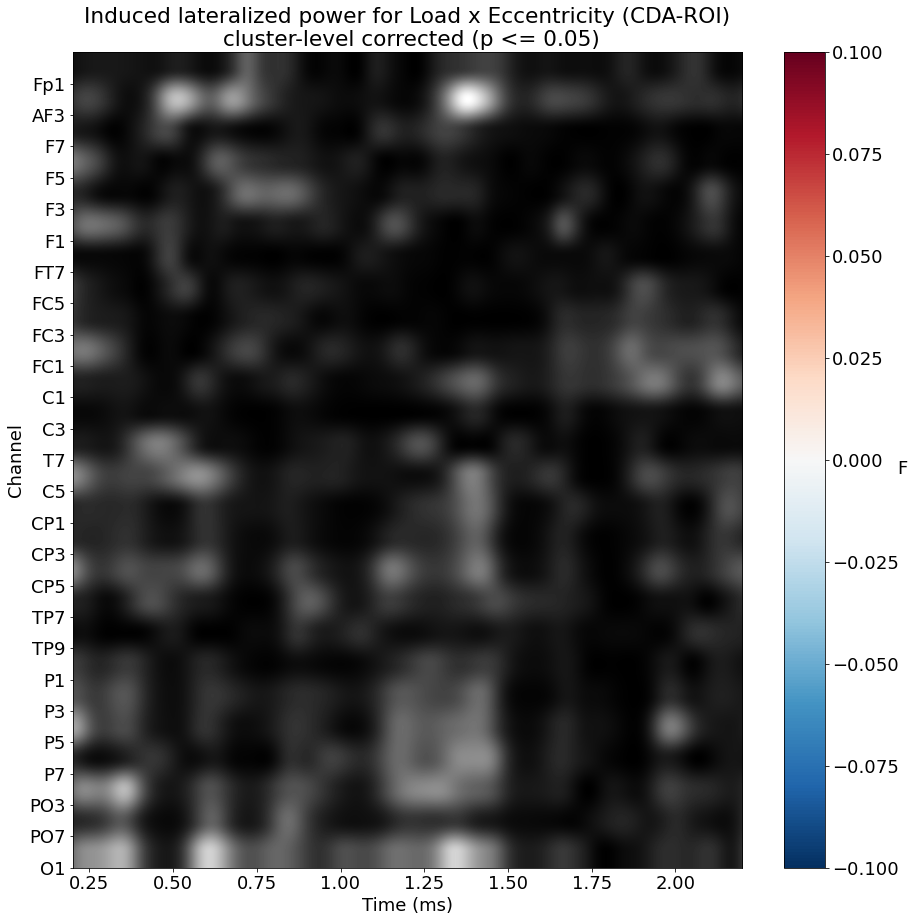

In [190]:

# Plot it:
T_obs_plot = np.ones_like(T_obs) *np.nan
for c, p in zip(clusters, cluster_p_values):
    if p < .05: 
        T_obs_plot[c] = T_obs[c]

f = plt.figure(figsize=(15,15))
for f_image, cmap in zip([T_obs, T_obs_plot], [plt.cm.gray, 'RdBu_r']):
    plt.imshow(f_image.reshape(n_chans, n_times), cmap=cmap, extent=[times[0], times[-1],
               0, n_chans], aspect='auto',
               origin='lower')
cb = plt.colorbar()
cb.set_label(label='F', rotation=0)
f.axes[0].set_yticks(range(len(ch_names_lat)))
f.axes[0].set_yticklabels(ch_names_lat)
# ytick_range = f.axes[0].get_ylim()
# ytick_vals = np.arange(*np.round(ytick_range), 2)
# f.axes[0].yaxis.set_ticks(ytick_vals)
plt.xlabel('Time (ms)')
plt.ylabel('Channel')
plt.title(f"Induced lateralized power for {effects_dict[effects]} (%s)\n"
          " cluster-level corrected (p <= 0.05)" % 'CDA-ROI')

plt.show()

Again, after MC correction, no effect is significant. Therefore, it seems reasonable and justified to reject the hypothesis that MemLoad or Ecc had a significant effect on alpha lateralization in our study. 